In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [13]:
from skimage.metrics import structural_similarity as peak_signal_noise_ratio

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [6]:
model = Autoencoder()
#model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [8]:
# Point to training loop video
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img_noisy = add_noise(img)
        recon = model(img_noisy)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0099
Epoch:2, Loss:0.0083
Epoch:3, Loss:0.0070
Epoch:4, Loss:0.0066
Epoch:5, Loss:0.0056
Epoch:6, Loss:0.0047
Epoch:7, Loss:0.0042
Epoch:8, Loss:0.0043
Epoch:9, Loss:0.0054
Epoch:10, Loss:0.0051


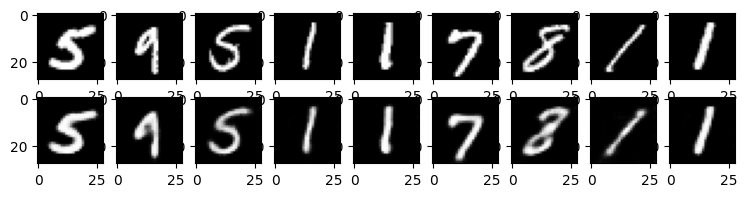

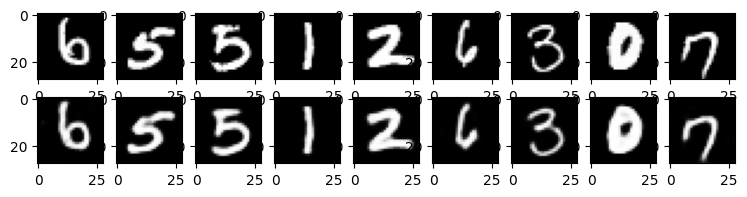

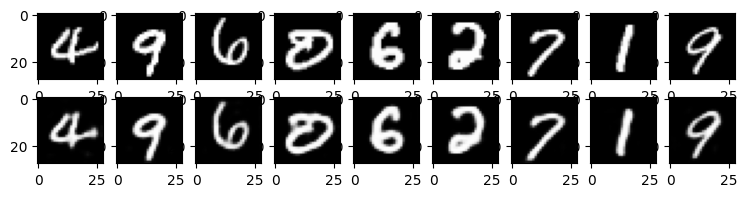

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

Mean PSNR Score: 0.5692


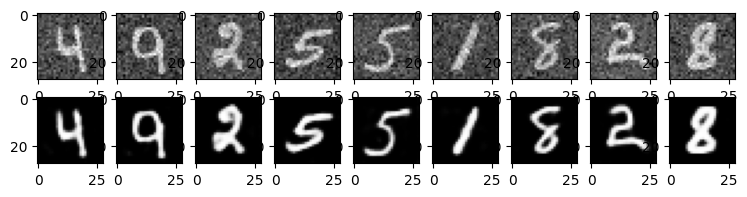

In [16]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.__next__()
#add noise to data
images = add_noise(images)
img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()

psnr_values = []
ssim_values = []
for i, img in enumerate(images[:9]):
    with torch.no_grad():
        #img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        #img2 = add_noise(img2) # -> use for Autoencoder_
        img2 = add_noise(img)
        pred = model(img2)
        recon = pred[0].detach().numpy()
        #recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        psnr_score = peak_signal_noise_ratio(img[0].numpy(), recon, data_range=1.0)
        psnr_values.append(psnr_score)

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        #plt.imshow(recon2[0])
        plt.imshow(recon)
        
print(f'Mean PSNR Score: {np.mean(psnr_values):.4f}')
plt.show()

### Ejercicios

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.

